<a href="https://colab.research.google.com/github/kkorhone/Python_Notebooks/blob/main/NusseltNumber.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Nusselt number estimation**

In [247]:
import numpy

# Borehole properties

r_borehole = 140e-3
L_borehole = 300

# Pipe properties

r_outer = 20e-3
r_inner = 17.6e-3
A_inner = numpy.pi * r_inner**2
d_inner = 2 * r_inner

# Refrigerant properties

k_fluid = 0.407
Cp_fluid = 4206
rho_fluid = 967
mu_fluid = 6.495e-3 # [Pa*s]
Q_fluid = 0.6e-3 # [m^3/s]
v_fluid = Q_fluid / A_inner

print(f"v_fluid = {v_fluid} m/s")

# The dimensionless numbers

Pr_fluid = Cp_fluid * mu_fluid / k_fluid
Re_fluid = rho_fluid * v_fluid * d_inner / mu_fluid

print(f"Pr_fluid = {Pr_fluid}")
print(f"Re_fluid = {Re_fluid}")

v_fluid = 0.6165609882175697 m/s
Pr_fluid = 67.12031941031941
Re_fluid = 3231.2162496297037


# Darcy friction factor

**1. Colebrook-White equation**

$\frac{1}{\sqrt{f}} = -2\cdot\log\left(\frac{\varepsilon/D}{3.7}+\frac{2.51}{Re\cdot\sqrt{f}}\right)$

**2. Haaland equation**

$\frac{1}{\sqrt{f}} = -1.8\cdot\log\left[\left(\frac{\varepsilon/D}{3.7}\right)^{1.11}+\frac{6.9}{Re}\right]$

**Solving for f gives**

$f = \frac{1}{\left\{-1.8\cdot\log\left[\left(\frac{\varepsilon/D}{3.7}\right)^{1.11}+\frac{6.9}{Re}\right]\right\}^2}$

**3. Swamee–Jain equation**

$f = \frac{0.25}{\left[\log\left(\frac{\varepsilon/D}{3.7}+\frac{5.74}{Re^{0.9}}\right)\right]^2}$

**4. Moody equation**

$f = 0.0055\cdot\left[1+\left(2\cdot{10^4}\cdot\frac{\varepsilon}{D}+\frac{10^6}{Re}\right)^{1/3}\right]$

where $\varepsilon$ is pipe roughness (for PE it is $0.0015-0.007\cdot{10^{-3}}$ m) and $D$ is pipe inner diameter (hydraulic diameter)

In [248]:
import scipy.optimize

epsilon = 0.001e-3

left = lambda f: 1 / numpy.sqrt(f)
rite = lambda f: -2 * numpy.log10((epsilon / d_inner) / 3.7 + 2.51 / (Re_fluid * numpy.sqrt(f)))

f = scipy.optimize.fminbound(lambda f: abs(left(f) - rite(f)), 1e-6, 1)

print(f"Colebrook-White: f = {f}")

f = 1 / (-1.8 * numpy.log10(((epsilon / d_inner) / 3.7)**1.11 + 6.9 / Re_fluid))**2

print(f"Haaland:         f = {f}")

f = 0.25 / (numpy.log10((epsilon / d_inner) / 3.7 + 5.74 / Re_fluid**0.9))**2

print(f"Swamee-Jain:     f = {f}")

f = 0.0055 * (1 + (2e4 * epsilon / d_inner + 1e6 / Re_fluid)**(1/3))

print(f"Moody:           f = {f}")

Colebrook-White: f = 0.042569543117713445
Haaland:         f = 0.043291566880123054
Swamee-Jain:     f = 0.043450500182242204
Moody:           f = 0.042725414947420964


# Nusselt number (and heat transfer coefficient)

$u = \frac{Re-2300}{10^4-2300}$

$f = 0.0055\cdot\left[1+\left(2\cdot{10^4}\cdot\frac{\varepsilon}{D}+100\right)^{1/3}\right]$

**1. Gnielinski correlation (FEFLOW White Paper)**

\begin{equation}
Nu =
\begin{cases}
  4.364 & \text{for laminar flow when $Re<2300$} \\
  (1-u)\cdot{4.364}+u\cdot\left\{\frac{(0.031/8)\cdot{10^4}\cdot{Pr}}{1+12.7\cdot\sqrt{0.031/8}\cdot(Pr^{2/3}-1)}\cdot\left[1+\left(\frac{D}{L}\right)^{2/3}\right]\right\} & \text{for transitional flow when $2300\le Re<10^4$} \\
  \frac{(f/8)\cdot{Re}\cdot{Pr}}{1+12.7\cdot\sqrt{f/8}\cdot{(Pr^{2/3}-1)}}\cdot\left[1+\left(\frac{D}{L}\right)^{2/3}\right] & \text{for turbulent flow when $Re\ge{10^4}$}
\end{cases}
\end{equation}

where $D$ is hydraulic diameter (pipe inner diameter) and $L$ is pipe length

**2. Dittus-Boelter correlation (Wikipedia)**

\begin{equation}
Nu =
\begin{cases}
4.364 & \text{for laminar flow when $Re < 2300$} \\
(1-u)\cdot{4.364}+u\cdot\left(0.023\cdot{10^{3.2}}\cdot{Pr^n}\right) & \text{for transitional flow when $2300 \le Re < 10000$} \\
0.023\cdot{Re^{0.8}}\cdot{Pr^n} & \text{for turbulent flow when $Re \ge 10000$}
\end{cases}
\end{equation}

$n$ is $0.4$ when fluid is being heated and $0.3$ when cooled

In [249]:
u = (Re_fluid - 2300) / (1e4 - 2300)

# Gnielinski correlation

if Re_fluid < 2300:
  print(f"Laminar flow:      {Re_fluid} < 2300")
elif Re_fluid < 1e4:
  print(f"Transitional flow: 2300 <= {Re_fluid} < 10000")
else:
  print(f"Turbulent flow:    {Re_fluid} >= 10000")

if Re_fluid < 2300:
  Nu_fluid = 4.364
elif Re_fluid < 1e4:
  Nu_fluid = (1-u)*4.364+u*((0.031/8)*1e4*Pr_fluid/(1+12.7*numpy.sqrt(0.031/8)*(Pr_fluid**(2/3)-1))*(1+(d_inner/L_borehole)**(2/3)))
else:
  Nu_fluid = (f/8)*Re_fluid*Pr_fluid/(1+12.7*numpy.sqrt(f/8)*(Pr_fluid**(2/3)-1))*(1+(d_inner/L_borehole)**(2/3))

h_fluid = Nu_fluid * k_fluid / d_inner

print(f"Gnielinski:        Nu_fluid = {Nu_fluid} (h_fluid={h_fluid})")

# Dittus-Boelter correlation

if Re_fluid < 2300:
  Nu_fluid = 4.364
elif Re_fluid < 1e4:
  Nu_fluid = (1-u)*4.364+u*(0.023*1e4**0.8*Pr_fluid**0.4)
else:
  Nu_fluid = 0.023*Re_fluid**0.8*Pr_fluid**0.4

h_fluid = Nu_fluid * k_fluid / d_inner

print(f"Dittus-Boelter:    Nu_fluid = {Nu_fluid} (h_fluid={h_fluid})")

Transitional flow: 2300 <= 3231.2162496297037 < 10000
Gnielinski:        Nu_fluid = 27.603111182349792 (h_fluid=319.16097304591943)
Dittus-Boelter:    Nu_fluid = 27.551565090766516 (h_fluid=318.56497136198783)


# Pressure loss in a BHE

**In a pipe shank**

$\Delta{p}_\text{pipe} = \frac{f\cdot\rho\cdot{v^2}\cdot{L}}{2\cdot{D}}$

**In a U-tube BHE**

$\Delta{p} = 2\cdot\Delta{p}_\text{pipe} = 2\cdot\frac{f\cdot\rho\cdot{v^2}\cdot{L}}{2\cdot{D}}$

# Pumping power

**1. U-tube**

$P = \frac{\Delta{p}\cdot\dot{Q}}{\eta}$

where $\dot{Q}$ is volumetric flow rate and $\eta$ is pump efficiency ($0-1$)

In [250]:
delta_p = 2 * f * rho_fluid * v_fluid**2 * L_borehole / (2 * d_inner)

print(f"delta_p = {delta_p*1e-3} kPa")

eta = 0.5

P = (2 * delta_p) * Q_fluid / eta

print(f"P = {P} W")

E = P * 8760

print(f"E = {E*1e-3} kWh")

delta_p = 133.85772472252262 kPa
P = 321.2585393340542 W
E = 2814.224804566315 kWh


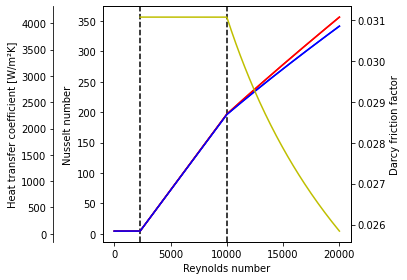

In [251]:
import matplotlib.pyplot as pyplot

Re_fluid = numpy.linspace(2, 20000, 201)

Nu_fluid1 = numpy.empty_like(Re_fluid)
Nu_fluid2 = numpy.empty_like(Re_fluid)

f = numpy.empty_like(Re_fluid)

for i in range(len(Re_fluid)):
  u = (Re_fluid[i] - 2_300) / (10_000 - 2_300)
  if Re_fluid[i] < 2300:
    f[i] = numpy.nan
    Nu_fluid1[i] = 4.364
    Nu_fluid2[i] = 4.364
  elif Re_fluid[i] < 10000:
    f[i] = 0.0055 * (1 + (20_000 * epsilon / d_inner + 1e6 / 10_000)**(1/3))
    Nu_fluid1[i] = (1-u)*4.364+u*((f[i]/8)*10_000*Pr_fluid/(1+12.7*numpy.sqrt(f[i]/8)*(Pr_fluid**(2/3)-1))*(1+(d_inner/L_borehole)**(2/3)))
    Nu_fluid2[i] = (1-u)*4.364+u*(0.023*10**3.2*Pr_fluid**0.4)
  else:
    f[i] = 0.0055 * (1 + (2e4 * epsilon / d_inner + 1e6 / Re_fluid[i])**(1/3))
    Nu_fluid1[i] = (f[i]/8)*Re_fluid[i]*Pr_fluid/(1+12.7*numpy.sqrt(f[i]/8)*(Pr_fluid**(2/3)-1))*(1+(d_inner/L_borehole)**(2/3))
    Nu_fluid2[i] = 0.023*Re_fluid[i]**0.8*Pr_fluid**0.4

_, ax1 = pyplot.subplots()

ax2 = ax1.twinx()
ax3 = ax1.twinx()

ax2.spines["left"].set_position(("axes", -0.2))
ax2.spines["left"].set_visible(True)

ax2.yaxis.set_label_position('left')
ax2.yaxis.set_ticks_position('left')

ax1.plot(Re_fluid, Nu_fluid1, "r-")
ax1.plot(Re_fluid, Nu_fluid2, "b-")

ax1.axvline(2_300, color="k", ls="--")
ax1.axvline(10_000, color="k", ls="--")

ax2.plot(Re_fluid, Nu_fluid1*k_fluid/d_inner, "r-")
ax2.plot(Re_fluid, Nu_fluid2*k_fluid/d_inner, "b-")

ax3.plot(Re_fluid, f, "y-")

ax1.set_ylabel("Nusselt number")
ax1.set_xlabel("Reynolds number")
ax2.set_ylabel(u"Heat transfer coefficient [W/m\xb2K]")
ax3.set_ylabel("Darcy friction factor")

pyplot.tight_layout()